In [1]:
import os
from glob import glob
from datetime import datetime

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets
import matplotlib.pyplot as plt
%matplotlib inline

### hyperparameter tunning

In [2]:
num_epochs = 50
batch_size = 32

learning_rate = 0.001

dropout_rate = 0.5

input_shape = (32,32,3)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape)

net = layers.Conv2D(32,(3,3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs= inputs, outputs=net, name = 'Basic_CNN')

In [4]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

### data preprocess

In [5]:
train_paths = glob('cifar/train/*.png')[:1000]
test_paths = glob('cifar/test/*.png')[:1000]

In [6]:
def get_class_name(path):
    return path.split('_')[-1].replace('.png','')

In [7]:
train_labels = [get_class_name(path) for path in train_paths]
class_names = np.unique(train_labels)

In [8]:
def get_label(path):
    fname = tf.strings.split(path, '_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png','')
    onehot = tf.cast(lbl_name == class_names, tf.uint8)
    return tf.argmax(onehot) # label번호를 반환

In [9]:
def load_image_label(path):
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    image = tf.cast(image, tf.float32) / 255.
    
    label = get_label(path)
    return image, label

In [10]:
def image_preprocess(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(load_image_label, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.map(image_preprocess, num_parallel_calls = AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

In [13]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_image_label, num_parallel_calls = AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.repeat()

### history 들여다보기

In [14]:
steps_per_epoch = len(train_paths) //batch_size
validation_steps = len(test_paths) // batch_size

history = model.fit_generator(
    train_dataset,
    steps_per_epoch = steps_per_epoch,
    validation_data = test_dataset,
    validation_steps = validation_steps,
    epochs = num_epochs,)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
31/31 [==============================] - 4s 125ms/step - loss: 2.3135 - accuracy: 0.1074 - val_loss: 2.3008 - val_accuracy: 0.0897
Epoch 2/50
31/31 [==============================] - 4s 117ms/step - loss: 2.2846 - accuracy: 0.1364 - val_loss: 2.2040 - val_accuracy: 0.1673
Epoch 3/50
31/31 [==============================] - 4s 123ms/step - loss: 2.1927 - accuracy: 0.1798 - val_loss: 2.1826 - val_accuracy: 0.1976
Epoch 4/50
31/31 [==============================] - 4s 120ms/step - loss: 2.1503 - accuracy: 0.1932 - val_loss: 2.0861 - val_accuracy: 0.2167
Epoch 5/50
31/31 [==============================] - 4s 124ms/step - loss: 2.0946 - accuracy: 0.2045 - val_loss: 2.0928 - val_accuracy: 0.2157
Epoch 6/50
31/31 [==============================] - 4s 116ms/step - loss: 2.0710 - accuracy: 0.2180 - val_loss: 1.9320 - val_accuracy: 0.2732
Epoch 7/50
31/31 [==============================] - 4s 117ms/step - loss

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 31}

In [18]:
new_model = history.model

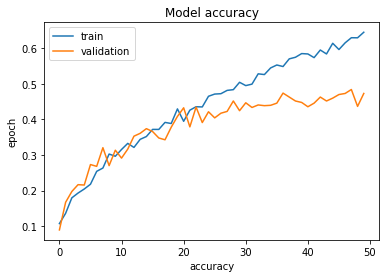

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

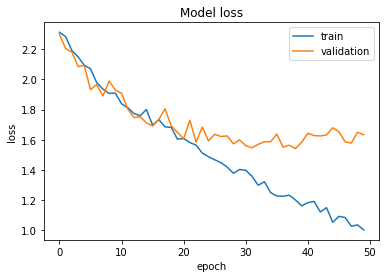

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'])
plt.show()